sample width: 2
channel num: 4
frames: 480704
multi_data.shape: (4, 480704)
[4.84062956e-10 4.84144946e-10 4.84391416e-10 4.84802809e-10
 4.85380347e-10 4.86125584e-10 4.87040519e-10 4.88127871e-10
 4.89390362e-10 4.90831598e-10 4.92455465e-10 4.94266350e-10
 4.96269248e-10 4.98469543e-10 5.00873232e-10 5.03486808e-10
 5.06317321e-10 5.09372322e-10 5.12659915e-10 5.16188869e-10
 5.19968457e-10 5.24008281e-10 5.28318833e-10 5.32910827e-10
 5.37795364e-10 5.42984102e-10 5.48488477e-10 5.54320034e-10
 5.60489710e-10 5.67007385e-10 5.73880832e-10 5.81114934e-10
 5.88709470e-10 5.96657168e-10 6.04940653e-10 6.13529783e-10
 6.22379204e-10 6.31428632e-10 6.40606901e-10 6.49840792e-10
 6.59066302e-10 6.68238687e-10 6.77336520e-10 6.86360802e-10
 6.95330682e-10 7.04278302e-10 7.13245019e-10 7.22278015e-10
 7.31426919e-10 7.40741912e-10 7.50269846e-10 7.60052798e-10
 7.70124631e-10 7.80509934e-10 7.91222143e-10 8.02263200e-10
 8.13622947e-10 8.25279289e-10 8.37199143e-10 8.49340376e-10
 8.616546

Text(0.5, 0, 'Time[frame]')

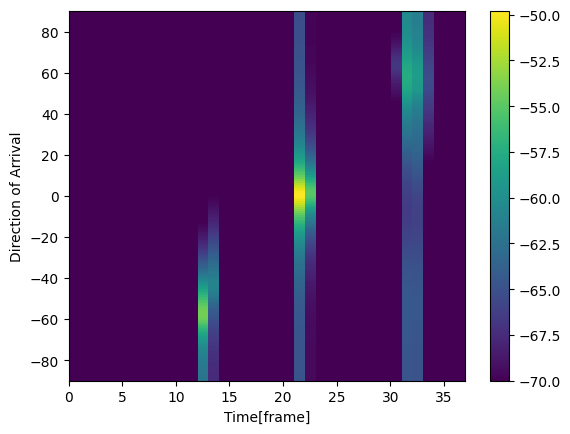

In [17]:
import wave as wave
import numpy as np
import scipy.signal as sg
import matplotlib.pyplot as plt


def load_onefile(file_name):
    """
    return M x frames ndarray
    """
    wav = wave.open(file_name)
    print("sample width:", wav.getsampwidth())
    print("channel num:", wav.getnchannels())
    print("frames:", wav.getnframes())

    M = wav.getnchannels()

    data = wav.readframes(wav.getnframes())
    data = np.frombuffer(data, dtype=np.int16)
    data = data/np.iinfo(np.int16).max

    multi_data = data.reshape(-1, M)
    multi_data = np.transpose(multi_data)
    print("multi_data.shape:", multi_data.shape)

    wav.close()

    return multi_data



# パラメータ
dir_name = "mic/"  # 録音データがあるディレクトリ
png_name = "music.png"  # 出力するグラフの画像名
n_mic = 4          # マイクの数
n_src = 1          # 音源の数
N     = 512        # 窓の大きさ
window = "hann"    # 窓の種類
d     = 0.01       # マイクの間隔[m]
c     = 340        # 音速[m/s]
freq_l = 800       # 空間スペクトルを計算する周波数の下限
freq_h = 3000      # 空間スペクトルを計算する周波数の下限

mic_alignments = np.array(
    [
        [-0.112, 0.0, 0.0],
        [-0.075, 0.0, 0.0],
        [-0.035, 0.0, 0.0],
        [0.113, 0.0, 0.0],
    ]
)

fs = 16000

# 周波数ビンに変換
k_l = int(freq_l/(fs/N))
k_h = int(freq_h/(fs/N))

file_name = "sep_0.wav"
audio = load_onefile(file_name)

# 短時間フーリエ変換(STFT)を行う X.shape=(n_mic, n_bin, n_frame)
f, t, X = sg.stft(audio, fs, window=window, nperseg=N)
n_bin = X.shape[1]

frame_set = 50
set_num = 1

theta = np.linspace(-90.0, 90.0, 181)
P_MU  = np.zeros((X.shape[2] // 50, theta.shape[0]))
a = np.zeros((theta.shape[0], n_mic, 1, n_bin), dtype=np.complex64) # アレイマニフォールドベクトル
for i, th in enumerate(theta):
    th = np.radians(th) # deg -> rad 変換
    # 直線状アレイのアレイ・マニフォールド・ベクトルの作成
    for k in range(n_bin):
        fk = fs*k/N  # 周波数
        for m in range(n_mic):
            delay = mic_alignments[m][0]*np.sin(th)/c # 遅延時間
            a[i,m,0,k] = np.exp(-1j*2*np.pi*fk*delay)


while set_num * frame_set < X.shape[2]:
    X_trimed = X[:, :, (set_num-1)*frame_set:set_num*frame_set]
    # 空間相関行列を求める
    XH = np.conjugate(X_trimed)
    XXH = np.einsum("mki,nki->mnki", X_trimed, XH)
    R = np.mean(XXH, axis=3)

    # 固有値を求めて大きい順に並べる
    eig_val = np.zeros((n_mic, n_bin), dtype=np.complex64)
    eig_vec = np.zeros((n_mic, n_mic, n_bin), dtype=np.complex64)
    beta = np.zeros(n_bin)
    for k in range(n_bin):
        eig_val_k, eig_vec_k = np.linalg.eig(R[:,:,k]) # 固有値、固有ベクトルを求める
        sort = np.argsort(-1.0*np.abs(eig_val_k))      # 大きい順にargsort
        eig_val[:,k] = eig_val_k[sort]                 # 固有値を大きい順に並べる
        eig_vec[:,:,k] = eig_vec_k[:,sort]             # 固有ベクトルも並べ替える
        
    W = eig_vec[:,n_src:,:]   # 音源の数より大きい番号の固有ベクトル    
    beta = np.sum(np.abs(eig_val[:n_src,:]), axis=0)  # 重みβを求める

    # 空間スペクトル作成
    for i, th in enumerate(theta):
        aH = np.conjugate(a[i])
        aHa = np.einsum("mik,mjk->ijk", aH, a[i])
        P_MU_th = np.einsum("mik,mek->iek", aH, W)
        P_MU_th = np.einsum("iek,jek->ijk", P_MU_th, np.conjugate(P_MU_th))
        P_MU_th = np.abs(aHa)/np.abs(P_MU_th)
        P_MU[set_num-1][i] = np.mean(beta[k_l:k_h+1]*P_MU_th[0,0,k_l:k_h+1])
    
    if set_num == 5 or set_num == 20:
        print(P_MU[set_num-1])

    # # グラフを出力
    # fig = plt.figure()
    # ax = fig.add_subplot(111)
    # ax.plot(theta, 10*np.log10(P_MU[set_num-1]), c="red")
    # ax.set_xlim([-90,90])
    # ax.set_xlabel("Direction [deg]") 
    # ax.set_ylabel("Spatial spectrum [dB]")
    # # fig.savefig(png_name)
        
    set_num = set_num + 1

P_MU = 10*np.log10(P_MU)
P_MU = P_MU.transpose()
# color_min = np.min(P_MU)
color_min = -70
color_max = np.max(P_MU)
plt.imshow(P_MU, interpolation="nearest", aspect="auto", extent=[0, P_MU.shape[1], -90, 90], vmin=color_min, vmax=color_max)
plt.colorbar()
plt.ylabel("Direction of Arrival")
plt.xlabel("Time[frame]")

# # 候補を出力
# index=sg.argrelmax(P_MU) # ピークのあるインデックスを求める
# sort=np.argsort(-1.0*P_MU[index])   # ピークの中でargsort
# for i in range(n_src):
#     print(theta[index[0][sort[i]]]) # 大きい順に方向を表示